In [4]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.autograd import Variable
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#import tqdm # this is for displaying a progress bar

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')       #Use this for Windows, Google Colab
elif torch.backends.mps.is_available():
    device = torch.device('mps')        #Use this for MacOS
else:
    device = torch.device('cpu')

[View our dataset on Google Drive here](https://drive.google.com/drive/folders/1F1LxmTDe8oy9KEKCgCGSUMAZuHX4ebRJ?usp=sharing)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

#Split data into train set, test set, validation set and their respective directories

In [21]:
#Create Dataloaders and Preprocess Data
#Based off of code from https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb

transformer=transforms.Compose([
    transforms.Resize((64,64)),       # TODO: decide what to modify this to
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),              # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


#Path variables to data directory
#data_path='/content/drive/MyDrive/SENG_474_Dataset_10k'       #Path on Google Drive
data_path='../SENG_474_Dataset_10k'                            #Local Path

# seed to keep random split the same each time
seed = 42
generator = torch.Generator().manual_seed(seed)

full_dataset = torchvision.datasets.ImageFolder(data_path, transform=transformer)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

#split the data
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)


train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True,
                          num_workers=4
                          )
test_loader = DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=True,   # - falsed out shuffle for now, to keep evaluation deterministic? - kedan
                         num_workers=4
                         )

#print to make sure classes were assigned correct label
print(full_dataset.class_to_idx)

#print number of images
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")


{'0-Human': 0, '1-AI': 1}
Total images: 20000
Training images: 16000
Testing images: 4000


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


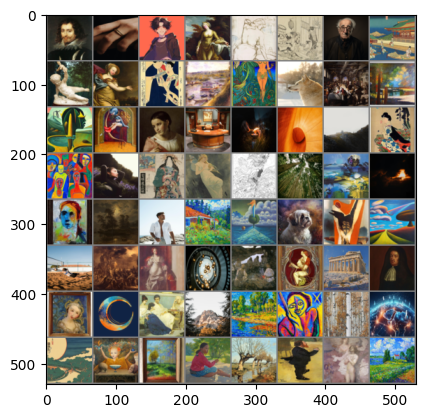

torch.Size([64, 3, 64, 64])


In [7]:
#PyTorch Tutorial 14 - Convolutional Neural Network (CNN) by Patrick Loeber on YouTube
# https://www.youtube.com/watch?v=pDdP0TFzsoQ

def showImages(img):
    #Show random images from the training set
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
showImages(torchvision.utils.make_grid(images))

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print(images.shape)
x = conv1(images)
x = pool(x)
x = conv2(x)

In [22]:
# Define Convolutional Neural Network model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)       # output: [6, 64, 64]
        self.pool = nn.MaxPool2d(2, 2)        # output: [6, 31, 31]
        self.conv2 = nn.Conv2d(6, 16, 3)      # output: [16, 14, 14] after pool
        self.fc1 = nn.Linear(16*14*14, 120)   # 120 -> 288? (20736/72)
        self.fc2 = nn.Linear(120, 18)
        self.fc3 = nn.Linear(18, 2)           # TODO: we can play with num of fc and nodes if we encounter under/overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # using relu for activation
        # print("After conv1 + pool:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print("After conv2 + pool:", x.shape)
        x = x.view(-1, 16*14*14)                # flatten the tensor before passing it to fc????
        # print("After flattening:", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

# Train the model

model = CNN().to(device)

# Define hyper-parameters
num_epochs = 8
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)     # TODO: SGD or Adam??? comapre training results
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, min_lr=1e-6)

# storing metrics for all epoches
train_losses = []

n_total_steps = len(train_loader)
halfway = n_total_steps//2

for epoch in range (num_epochs):
    #storing running total of loss for current epoch
    running_loss_first = 0.0
    running_loss_second = 0.0

    current_lr = optimizer.param_groups[0]['lr']
    print(f'=== Epoch {epoch+1}: Current LR: {current_lr} ===')

    for i, (images, labels) in enumerate(train_loader): # TODO: it seems that we have few corrupted images
        images = images.to(device)
        labels = labels.to(device)

        # Forward propagation
        outputs = model(images) # predictions
        loss = criterion(outputs, labels)

        # Backward propagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        # applied every batch

        if i < halfway:
            running_loss_first += loss.item()
        else:
            running_loss_second += loss.item()

        # print out our model's performance every 50 iterations
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')

    
    scheduler.step(loss) # applied every epoch

    # store average loss for this epoch
    train_losses.append(running_loss_first / halfway)
    train_losses.append(running_loss_second / (n_total_steps - halfway))

print('Finished Training')

path = 'models/model2.pt' 
def save_model(model, path):
  torch.save(model.state_dict(), path)  # saves model to a file

save_model(model, path)

=== Epoch 1: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/8], Step [50/250, Loss: 0.5609]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/8], Step [100/250, Loss: 0.5380]
Epoch [1/8], Step [150/250, Loss: 0.4610]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/8], Step [200/250, Loss: 0.5359]
Epoch [1/8], Step [250/250, Loss: 0.4550]
=== Epoch 2: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/8], Step [50/250, Loss: 0.4584]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/8], Step [100/250, Loss: 0.4948]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/8], Step [150/250, Loss: 0.6032]
Epoch [2/8], Step [200/250, Loss: 0.3868]
Epoch [2/8], Step [250/250, Loss: 0.4543]
=== Epoch 3: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/8], Step [50/250, Loss: 0.3771]
Epoch [3/8], Step [100/250, Loss: 0.4309]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/8], Step [150/250, Loss: 0.5488]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [3/8], Step [200/250, Loss: 0.4394]
Epoch [3/8], Step [250/250, Loss: 0.5426]
=== Epoch 4: Current LR: 0.001 ===
Epoch [4/8], Step [50/250, Loss: 0.3743]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/8], Step [100/250, Loss: 0.3913]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/8], Step [150/250, Loss: 0.5002]
Epoch [4/8], Step [200/250, Loss: 0.5882]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [4/8], Step [250/250, Loss: 0.4359]
=== Epoch 5: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/8], Step [50/250, Loss: 0.3015]
Epoch [5/8], Step [100/250, Loss: 0.3480]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/8], Step [150/250, Loss: 0.3709]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [5/8], Step [200/250, Loss: 0.3646]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/8], Step [250/250, Loss: 0.3642]
=== Epoch 6: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/8], Step [50/250, Loss: 0.3429]
Epoch [6/8], Step [100/250, Loss: 0.4632]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/8], Step [150/250, Loss: 0.3310]
Epoch [6/8], Step [200/250, Loss: 0.4776]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [6/8], Step [250/250, Loss: 0.3462]
=== Epoch 7: Current LR: 0.001 ===


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/8], Step [50/250, Loss: 0.2703]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [7/8], Step [100/250, Loss: 0.4319]
Epoch [7/8], Step [150/250, Loss: 0.4127]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/8], Step [200/250, Loss: 0.5266]
Epoch [7/8], Step [250/250, Loss: 0.4359]
=== Epoch 8: Current LR: 0.001 ===
Epoch [8/8], Step [50/250, Loss: 0.3714]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [8/8], Step [100/250, Loss: 0.3949]


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/8], Step [150/250, Loss: 0.5132]
Epoch [8/8], Step [200/250, Loss: 0.4295]
Epoch [8/8], Step [250/250, Loss: 0.3998]
Finished Training


In [24]:
# Test the model

# Call this function in case you want to use an older model
def load_model(path):
      model = CNN()                      # create empty model
      model.load_state_dict(torch.load(path))      # load a static dict with trained parameters from file to the model
      model.eval()                                # set model to evaluation mode (was previously incorrectly set to train)
      return model

model.eval()  # might wanna do this to set model to evaluation mode -Jasmine
with torch.no_grad():
    all_pred_labels = []
    all_labels = []

    TP = 0
    m_samples = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # max() returns (value, index)
        m_samples += labels.size(0)
        TP += (predicted == labels).sum().item()

        # convert predicted and actual labels into numpy and add to lists
        all_pred_labels.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # for evaluation we can only print accuracy since we have a perfectly balanced set
    acc = 100.0 * TP / m_samples
    print(f'Accuracy of predicting AI: {acc} %')


/Users/sonya/Desktop/CompSci/SENG474/Project/AI_detector/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of predicting AI: 80.35 %


Accuracy: 80.35%
Precision: 87.88%
Recall: 70.52%
F1 Score: 78.25%


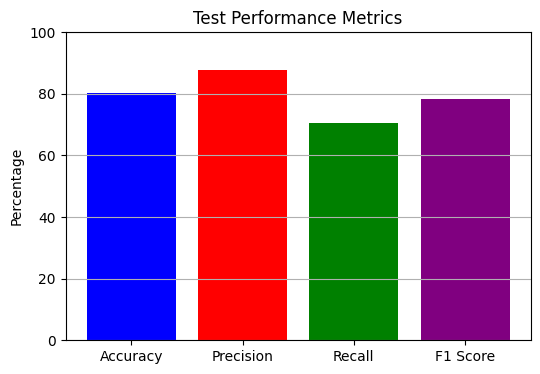

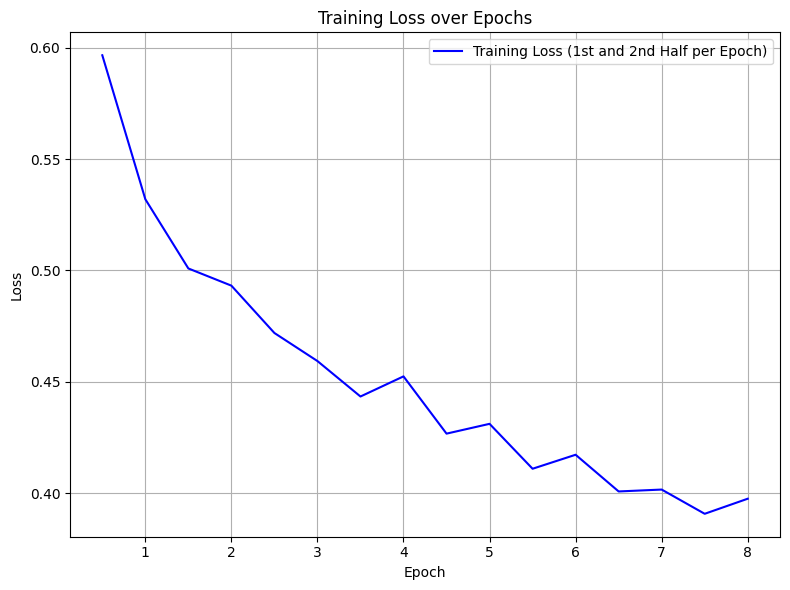

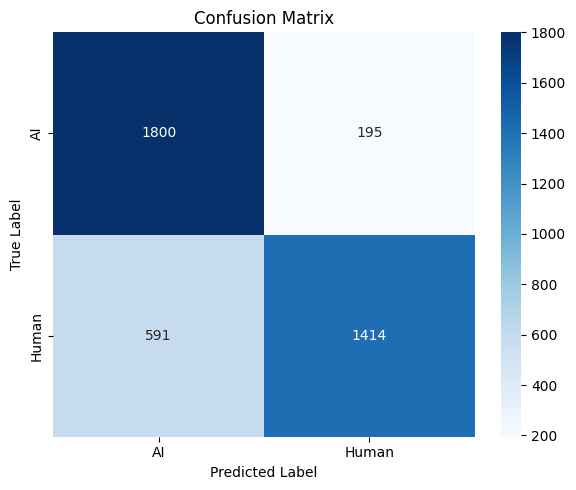

In [25]:
# compute accuracy, precision, recall, and f1
accuracy = 100.0 * np.mean(np.array(all_pred_labels) == np.array(all_labels))
precision = 100.0 * precision_score(all_labels, all_pred_labels, zero_division=0)
recall = 100.0 * recall_score(all_labels, all_pred_labels, zero_division=0)
f1 = 100.0 * f1_score(all_labels, all_pred_labels, zero_division=0)

# print metrics first
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# bar chart for test metrics
plt.figure(figsize=(6, 4))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.bar(labels, metrics, color=['blue', 'red', 'green', 'purple'])
plt.title('Test Performance Metrics')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

# plot loss vs epochs
plt.figure(figsize=(8, 6))
x_vals = [i / 2 for i in range(1, len(train_losses) + 1)]
plt.plot(x_vals, train_losses, label='Training Loss (1st and 2nd Half per Epoch)', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot confusion matrix
cm = confusion_matrix(all_labels, all_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()